In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchsummary import summary

import matplotlib.pyplot as plt

from time import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 128
DROP_OUT = 0.5
WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
EPOCHS = 100

In [4]:
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
traindata = datasets.FashionMNIST(root = '/drive/MyDrive/datasetfolder', train = True, download = True, transform = trans)
testdata = datasets.FashionMNIST(root = '/drive/MyDrive/datasetfolder', train = False, download = True, transform = trans)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /drive/MyDrive/datasetfolder/FashionMNIST/raw/train-images-idx3-ubyte.gz to /drive/MyDrive/datasetfolder/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /drive/MyDrive/datasetfolder/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /drive/MyDrive/datasetfolder/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /drive/MyDrive/datasetfolder/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /drive/MyDrive/datasetfolder/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /drive/MyDrive/datasetfolder/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /drive/MyDrive/datasetfolder/FashionMNIST/raw



In [6]:
trainloader = DataLoader(traindata, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(testdata, batch_size = BATCH_SIZE)

In [7]:
imgs, labels = next(iter(trainloader))
print(imgs.shape)
print(labels.shape)

torch.Size([128, 1, 224, 224])
torch.Size([128])


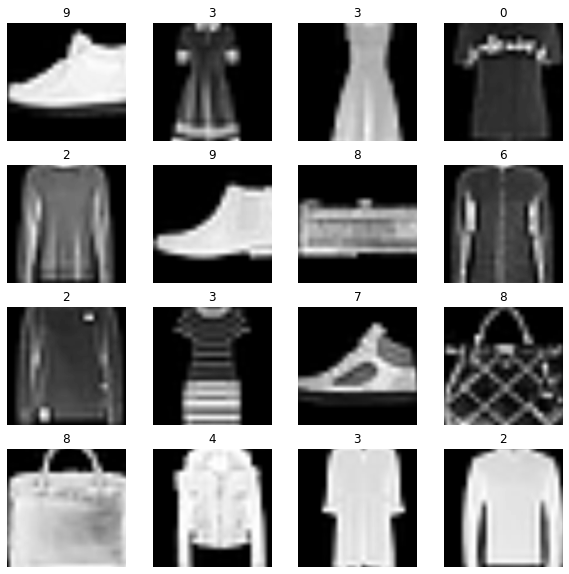

In [8]:
plt.figure(figsize=  (10, 10))
for i in range(1, 16+1):
  plt.subplot(4, 4, i)
  x, y = imgs[i], labels[i].item()
  plt.imshow(x.squeeze(), cmap = 'gray')
  plt.title(y)
  plt.axis('off')

In [17]:
class AlexNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(AlexNet, self).__init__()

    self.c1 = nn.Conv2d(in_channels = 1, out_channels = 96, kernel_size = 11, stride = 4, padding = 2, bias = False)
    self.n1 = nn.LocalResponseNorm(size= 5, k= 2, beta = 0.75, alpha = 0.0001)
    self.p1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.c2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, padding = 2)
    self.n2 = nn.LocalResponseNorm(size= 5, k= 2, beta = 0.75, alpha = 0.0001)
    self.p2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.c3 = nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, padding = 1, bias = False)
    self.c4 = nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, padding = 1)
    self.c5 = nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, padding = 1)
    self.p5 = nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.dropout = nn.Dropout(0.5)
    self.fc6 = nn.Linear(256*6*6, 4096)
    self.fc7 = nn.Linear(4096, 4096)
    self.fc8 = nn.Linear(4096, num_classes)

  def forward(self, x):
    x = torch.relu(self.c1(x))
    x = self.p1(self.n1(x))

    x = torch.relu(self.c2(x))
    x = self.p2(self.n2(x))

    x = torch.relu(self.c3(x))
    
    x = torch.relu(self.c4(x))

    x = torch.relu(self.c5(x))
    x = self.p5(x)

    x = x.view(-1, 256 * 6 * 6)
    

    x = torch.relu(self.fc6(self.dropout(x)))

    x = torch.relu(self.fc7(self.dropout(x)))
    
    x = self.fc8(x)

    return x
    


In [18]:
model = AlexNet().to(device)
summary(model, input_size = (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,616
 LocalResponseNorm-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
 LocalResponseNorm-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         884,736
            Conv2d-8          [-1, 384, 13, 13]       1,327,488
            Conv2d-9          [-1, 256, 13, 13]         884,992
        MaxPool2d-10            [-1, 256, 6, 6]               0
          Dropout-11                 [-1, 9216]               0
           Linear-12                 [-1, 4096]      37,752,832
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

In [20]:
def weight_initialization(model):
  if type(model) == nn.Conv2d and nn.Linear: 
    torch.nn.init.normal_(model.weight.data, 0, 0.01)
  #model.bias.data.fill_(1.0)
  print('init success')

In [21]:
model.apply(weight_initialization)

init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success


AlexNet(
  (c1): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
  (n1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (p1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (n2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (p2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (c4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc6): Linear(in_features=9216, out_features=4096, bias=True)
  (fc7): Linear(in_features=4096, out_features=4096, bias=True)
  (fc8): Linear(in_features=4096, out_features=10, 

In [22]:
def accuracy_test(output, target):
  pred = output.argmax(dim = 1, keepdim = True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [23]:
optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
params = {'Train_Loss' :[],
          'Test_Loss' : [],
          'Train_Accuracy': [],
          'Test_Accuracy': []
          }
for epoch in range(EPOCHS):
  start_time = time()

  for idx, (imgs, labels) in enumerate(trainloader):
    imgs = imgs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)
    
    loss = criterion(pred, labels)
    
    loss.backward()

    correct = accuracy_test(pred, labels)
    correct_rate = correct / len(imgs) * 100
    optimizer.step()
    model.eval()
    with torch.no_grad():
      for idx, (imgs, labels) in enumerate(testloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        pred = model(imgs)

        test_loss = criterion(pred, labels)

        test_correct = accuracy_test(pred, labels)
        test_correct_rate = test_correct / len(imgs) * 100
  end_time = time()
  params['Train_Loss'].append(loss.item())
  params['Train_Accuracy'].append(correct_rate)
  params['Test_Loss'].append(test_loss.item())
  params['Test_Accuracy'].append(test_correct_rate)
  print('EPOCH : ', epoch+1, 'TRAIN LOSS : '.format(loss.item()), 'TRAIN ACC : {:.2f}'.format(correct_rate), 'TIME : {:.1f}minute'.format((end_time - start_time) / 60))